In [4]:
import itertools

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

matplotlib.rcParams.update({'figure.figsize': (15, 9)})
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({'font.family': 'Helvetica, Arial, sans-serif'})
%config InlineBackend.figure_format = 'retina'

In [5]:
# Transforms an RGB matrix of pixels to a Grayscale matrix of pixels
#[CITE] https://stackoverflow.com/q/12201577
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

# Convert a array of lists to a singular list
#[CITE] https://stackoverflow.com/a/716482
def listsToList(listOfLists):
    return list(itertools.chain.from_iterable(listOfLists))

# Converts a image to a grayscale singular array of pixels
maxSize=(128,128)
def imageToArray(img):
    return listsToList(rgb2gray(np.asarray(img)))


In [7]:
%%time
file_prefix = 'data/'
data = {'Id': [], 'ImageData': [], 'ImageSize': [], 'ImageClass': []}
maxSize = (128,128)

for i in range(0,2000):
    img = Image.open(f'{file_prefix}cat.{i}.jpg')
    smallImage = img.resize(maxSize, Image.ANTIALIAS)
    
    data['Id'].append(f'cat_{i}')
    data['ImageData'].append(imageToArray(smallImage))
    data['ImageSize'].append(maxSize)
    data['ImageClass'].append(0)
    
    img = Image.open(f'{file_prefix}dog.{i}.jpg')
    smallImage = img.resize(maxSize, Image.ANTIALIAS)
    
    data['Id'].append(f'dog_{i}')
    data['ImageData'].append(imageToArray(smallImage))
    data['ImageSize'].append(maxSize)
    data['ImageClass'].append(1)

ds = pd.DataFrame(data=data)

CPU times: user 16.4 s, sys: 2.44 s, total: 18.8 s
Wall time: 18.9 s


In [8]:
ds.head()

,Id,ImageClass,ImageData,ImageSize
0,cat_0,0,"[167.8626, 172.8621, 173.862, 178.8615, 181.64...","(128, 128)"
1,dog_0,1,"[116.9543, 107.2973, 122.0678, 157.4403, 160.1...","(128, 128)"
2,cat_1,0,"[43.045, 43.9139, 41.6691, 56.7816, 43.256, 44...","(128, 128)"
3,dog_1,1,"[171.9092, 117.6175, 134.1383, 133.545, 134.17...","(128, 128)"
4,cat_2,0,"[56.7063, 39.2242, 41.8541, 59.5965, 84.8112, ...","(128, 128)"


In [9]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
Id            4000 non-null object
ImageClass    4000 non-null int64
ImageData     4000 non-null object
ImageSize     4000 non-null object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [10]:
from sklearn.decomposition import PCA

#[CITE] Eric Larson - 04. Dimension Reduction and Images Notebook

# Convert the series to a matrix 4000x16384
X = np.asarray(ds['ImageData'].tolist())

# Number of dimensions!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!IS THIS ENOUGH PAUL??????????????????????????
numComp = 1500
pca = PCA(n_components=numComp)
%time pca.fit(X)

CPU times: user 2min 16s, sys: 16.4 s, total: 2min 33s
Wall time: 24.6 s


PCA(copy=True, iterated_power='auto', n_components=1500, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [11]:
# Use 128x128 because that is the the maxSize defined above
eigenfaces = pca.components_.reshape((numComp, 128, 128))

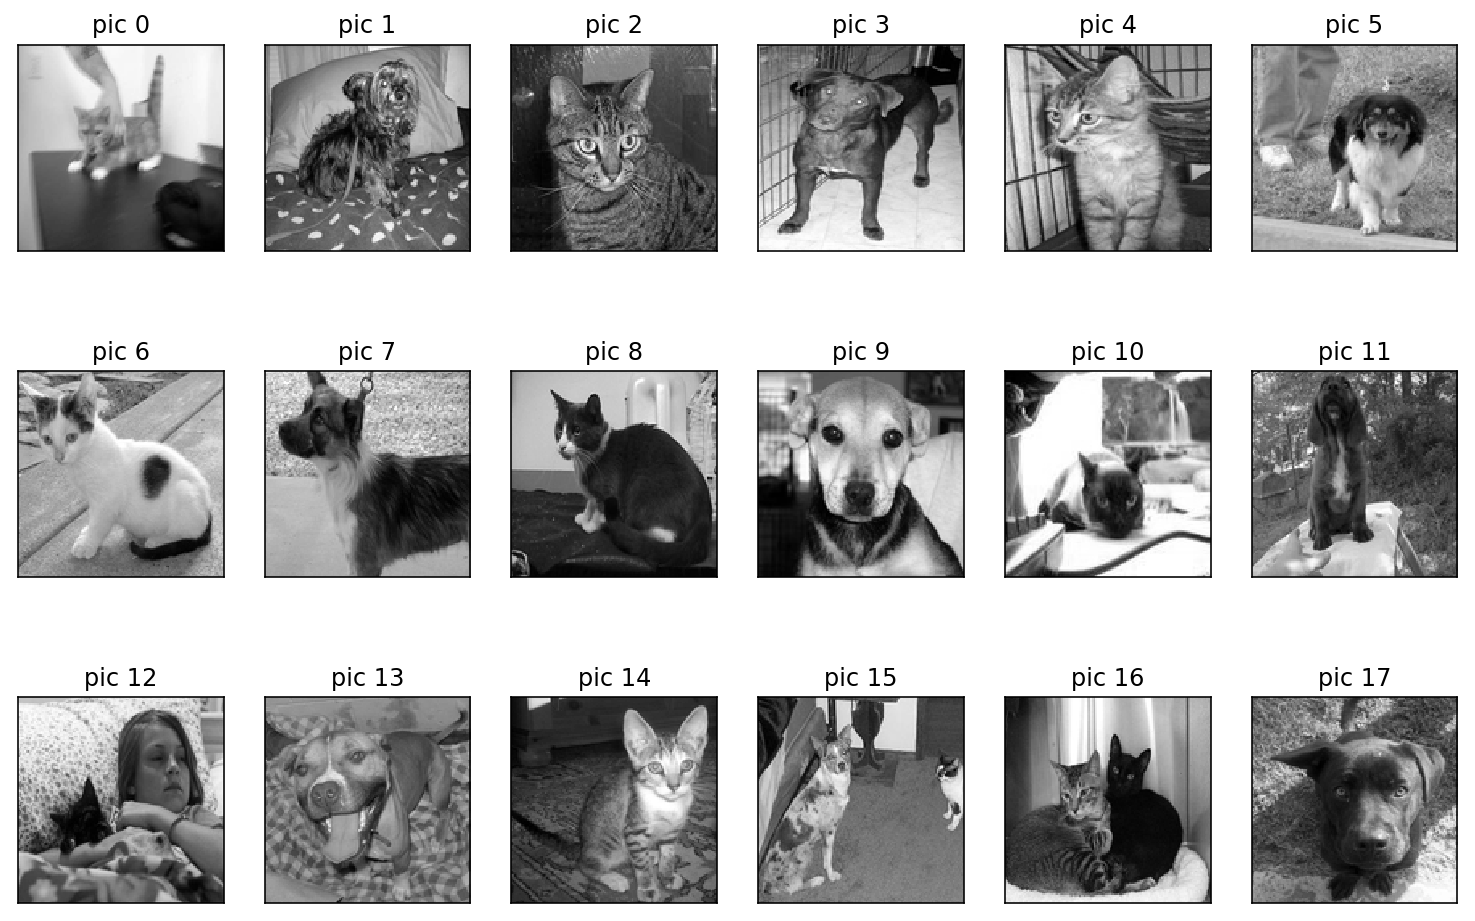

In [12]:
%matplotlib inline
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
img_titles = ["pic %d" % i for i in range(X.shape[0])]
plot_gallery(X, img_titles, 128, 128)

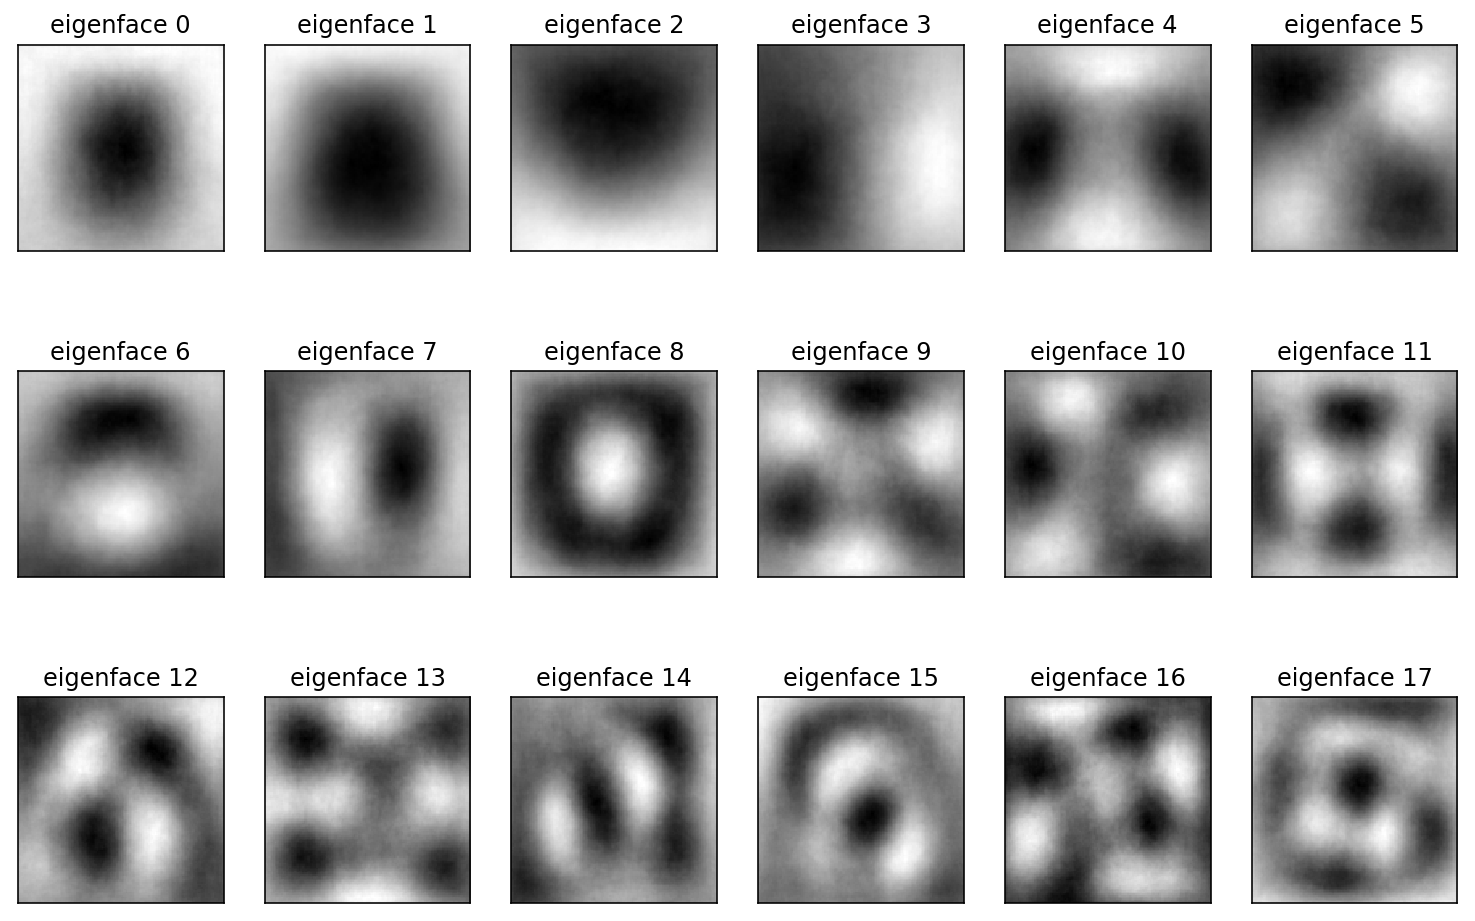

In [13]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 128, 128)

In [14]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 15
img = X[idx_to_reconstruct].reshape(1,-1)
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,img)

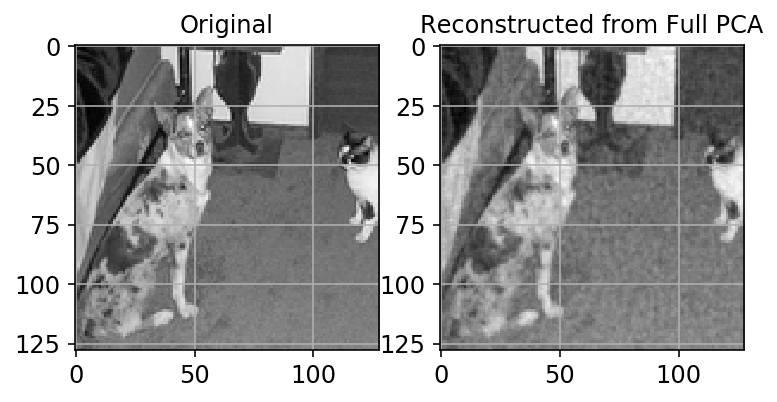

In [15]:
plt.subplot(1,2,1)
plt.imshow(X[idx_to_reconstruct].reshape(maxSize), cmap=plt.cm.gray)
plt.title('Original')
plt.grid()
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape(maxSize), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid()

# END CITATION

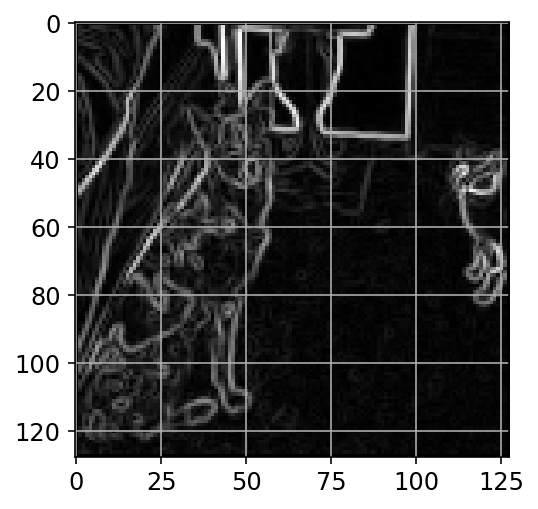

In [16]:
from skimage.filters import sobel_h, sobel_v

img = np.asarray(ds.iloc[15]['ImageData']).reshape(maxSize)

gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
plt.imshow(gradient_mag, cmap=plt.cm.gray)
plt.grid()